## Customer Lifetime Value Implementation in Python

In [1]:
#import modules
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np

In [2]:
data = pd.read_excel("Online Retail.xlsx")

In [3]:
data=data.drop_duplicates()

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.shape

(536641, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      536641 non-null object
StockCode      536641 non-null object
Description    535187 non-null object
Quantity       536641 non-null int64
InvoiceDate    536641 non-null datetime64[ns]
UnitPrice      536641 non-null float64
CustomerID     401604 non-null float64
Country        536641 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.8+ MB


In [7]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [8]:
data= data[pd.notnull(data['CustomerID'])]

### Where most of the customers are from?

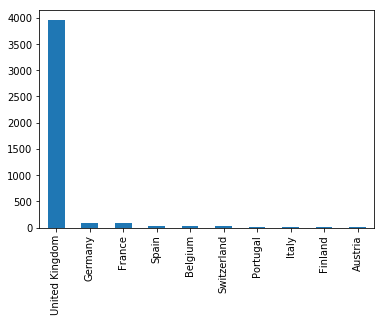

In [10]:
filtered_data=data[['Country','CustomerID']].drop_duplicates()
filtered_data.Country.value_counts()[:10].plot(kind='bar')
plt.show()

## Lets look at UK

In [11]:
uk_data=data[data.Country=='United Kingdom']
uk_data = uk_data[(uk_data['Quantity']>0)]

In [12]:
#most bought product in UK
uk_data['Description'].value_counts()[:10]

WHITE HANGING HEART T-LIGHT HOLDER    1929
JUMBO BAG RED RETROSPOT               1461
REGENCY CAKESTAND 3 TIER              1417
ASSORTED COLOUR BIRD ORNAMENT         1320
PARTY BUNTING                         1301
LUNCH BAG RED RETROSPOT               1135
LUNCH BAG  BLACK SKULL.               1022
SET OF 3 CAKE TINS PANTRY DESIGN      1013
PAPER CHAIN KIT 50'S CHRISTMAS         967
HEART OF WICKER SMALL                  946
Name: Description, dtype: int64

In [13]:
#which customer bought the most number of items?
cust_data=pd.DataFrame()
cust_data['CustomerID']=list(set(data['CustomerID']))
cust_data=cust_data.set_index('CustomerID')
for cust_id in cust_data.index:
    cust_data.at[cust_id,'Number_of_items']=(len(uk_data[uk_data['CustomerID']==cust_id]['Description']))
cust_data=cust_data.sort_values('Number_of_items',ascending=False)

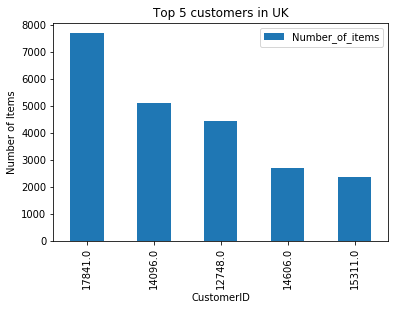

In [14]:
cust_data.head(5).plot(kind='bar')
plt.ylabel('Number of Items')
plt.title('Top 5 customers in UK')
plt.show()

In [15]:
uk_data[uk_data['Quantity']==uk_data['Quantity'].describe()['max']] # most bought quantity

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


### RFM Analysis for Customer Segmentation

In [16]:
uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']
uk_data['InvoiceDate'].min(),uk_data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [17]:
PRESENT = dt.datetime(2019,4,15)
uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])

Here, we are going to perform following opertaions:

- For Recency, Calculate the number of days between present date and date of last purchase each customer.
- For Frequency, Calculate the number of orders for each customer.
- For Monetary, Calculate sum of purchase price for each customer.

In [18]:
rfm= uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [19]:
rfm.columns=['recency','frequency','monetary'] #['InvoiceDate', 'InvoiceNo', 'TotalPrice']

In [20]:
rfm['recency'] = rfm['recency'].astype(int)
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,3008,1,77183.60
12747.0,2685,103,4196.01
12748.0,2683,4413,33053.19
12749.0,2686,199,4090.88
12820.0,2686,59,942.34


#### Computing Quantile of RFM values
Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

In [21]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,3008,1,77183.60,4,4,1
12747.0,2685,103,4196.01,1,1,1
12748.0,2683,4413,33053.19,1,1,1
12749.0,2686,199,4090.88,1,1,1
12820.0,2686,59,942.34,1,2,2


#### RFM Result Interpretation
Combine all three quartiles(r_quartile,f_quartile,m_quartile) in a single column, this rank will help us to segment the customers well group.

In [22]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)

# Filter out Top/Best cusotmers
rfm[rfm['RFM_Score']=='111'].sort_values('monetary', ascending=False).head(10)

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
18102.0,2683,431,259657.30,1,1,1,111
17450.0,2691,336,194390.79,1,1,1,111
17511.0,2685,963,91062.38,1,1,1,111
16684.0,2687,277,66653.56,1,1,1,111
14096.0,2687,5111,65164.79,1,1,1,111
13694.0,2686,568,65039.62,1,1,1,111
15311.0,2683,2366,60632.75,1,1,1,111
13089.0,2685,1814,58762.08,1,1,1,111
15769.0,2690,130,56252.72,1,1,1,111


## Customer Lifetime Value

In [23]:
uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
#Calulate total purchase
uk_data['TotalPurchase'] = uk_data['Quantity'] * uk_data['UnitPrice']

Here, we are going to perform the following operations:

- Calculate the number of days between the present date and the date of last purchase from each customer.
- Calculate the number of orders for each customer.
- Calculate sum of purchase price for each customer.

In [24]:
uk_data_group=uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                                 'InvoiceNo': lambda num: len(num),
                                                 'Quantity': lambda quant: quant.sum(),
                                                 'TotalPurchase': lambda price: price.sum()})

In [25]:
uk_data_group.head()

,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4413,25288,33053.19
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


### Customer ID vs num of InvoiceNo.

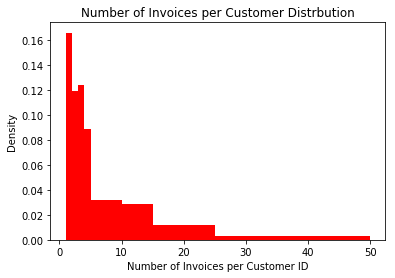

***************************************************************


In [26]:
plt.hist(uk_data_group['InvoiceNo'],bins=[1,2,3,4,5,10,15,25,50],density=True,color='r')
plt.xlabel('Number of Invoices per Customer ID')
plt.ylabel('Density')
plt.title('Number of Invoices per Customer Distrbution')
plt.show()
print('*'*63)

In [27]:
# Change the name of columns
uk_data_group.columns=['num_days','num_transactions','num_units','spent_money']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4413,25288,33053.19
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


   __CLTV__ = ((Average Order Value x Purchase Frequency) / Churn Rate) x Profit margin.

   __Customer Value__ = Average Order Value * Purchase Frequency


#### 1. Calculate Average Order Value

In [28]:
# Average Order Value
uk_data_group['avg_order_value']=uk_data_group['spent_money']/uk_data_group['num_transactions']

#### 2. Calculate Purchase Frequency

In [29]:
purchase_frequency=sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]

#### 3. Calculate Repeat Rate and Churn Rate

In [30]:
# Repeat Rate
repeat_rate=uk_data_group[uk_data_group.num_transactions > 1].shape[0]/uk_data_group.shape[0]
#Churn Rate
churn_rate=1-repeat_rate

In [31]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value
CustomerID,,,,,
12346.0,0,1,74215,77183.60,77183.600000
12747.0,366,103,1275,4196.01,40.737961
12748.0,372,4413,25288,33053.19,7.489959
12749.0,209,199,1471,4090.88,20.557186
12820.0,323,59,722,942.34,15.971864


In [32]:
purchase_frequency,repeat_rate,churn_rate

(89.06579954093344, 0.9818923743942872, 0.018107625605712774)

#### 4. Calculate Profit Margin

Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain. Let's assume our business has approx 5% profit on the total sale.

In [33]:
# Profit Margin
uk_data_group['profit_margin']=uk_data_group['spent_money']*0.05

### 5. Calcualte Customer Lifetime Value

In [34]:
# Customer Value
uk_data_group['CLV']=(uk_data_group['avg_order_value']*purchase_frequency)/churn_rate
#Customer Lifetime Value
uk_data_group['cust_lifetime_value']=uk_data_group['CLV']*uk_data_group['profit_margin']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
CustomerID,,,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800,3.796422e+08,1.465108e+12
12747.0,366,103,1275,4196.01,40.737961,209.8005,2.003774e+05,4.203928e+07
12748.0,372,4413,25288,33053.19,7.489959,1652.6595,3.684079e+04,6.088528e+07
12749.0,209,199,1471,4090.88,20.557186,204.5440,1.011144e+05,2.068235e+07
12820.0,323,59,722,942.34,15.971864,47.1170,7.856065e+04,3.701542e+06


### Prediction Model for CLTV

Predict CLTV using Linear Regression Model.

In [35]:
uk_data['month_yr'] = uk_data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))
sale=uk_data.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00
2,12748.0,1065.57,896.16,4185.00,999.00,381.59,417.12,1081.45,1923.62,1165.37,2223.17,10453.69,2199.30,6062.15
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77


In [36]:
sale['CLV']=sale.iloc[:,2:].sum(axis=1)# sum of all sale values
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,77183.60
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00,4196.01
2,12748.0,1065.57,896.16,4185.00,999.00,381.59,417.12,1081.45,1923.62,1165.37,2223.17,10453.69,2199.30,6062.15,31987.62
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00,4090.88
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77,942.34


#### Selecting Features

In [37]:
X=sale[['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011','Jun-2011','May-2011']] # last 8 months in data
y=sale[['CLV']]

#### Model Development

In [38]:
#split training set and test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

C:\Users\praga\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [39]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [40]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[120.749364]
[[1.00010436 1.02673712 1.16654426 1.04383429 1.16733906 1.36398485
  1.01677176 2.38174784]]


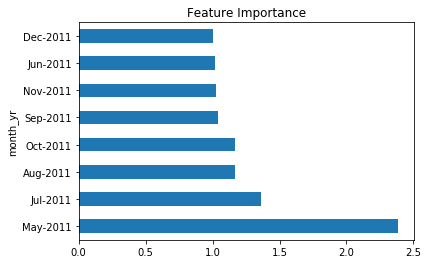

In [41]:
feat_importances = pd.Series(linreg.coef_[0], index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [42]:
from sklearn import metrics
# compute the R Square for model
print("R-Square:",round(metrics.r2_score(y_test, y_pred),5))

R-Square: 0.98144


### Model Evaluation
For regression problems following evaluation metrics used :

- Mean Absolute Error (MAE) is the mean of the absolute value of the errors.
- Mean Squared Error (MSE) is the mean of the squared errors.
- Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors.

In [43]:
# calculate MAE using scikit-learn
print("MAE:",round(metrics.mean_absolute_error(y_test,y_pred),2))
#calculate mean squared error
print("MSE",round(metrics.mean_squared_error(y_test, y_pred),2))
# compute the RMSE of our predictions
print("RMSE:",round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

MAE: 409.27
MSE 1173256.78
RMSE: 1083.17
